In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [3]:
import tensorflow as tf


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import math
from IPython import display


In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [6]:
train_images.shape[0]

60000

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [9]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)


In [10]:
train_dataset

<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [25]:
class Generator(tf.keras.Model):
    def __init__(self,input_shape1):
        super(Generator,self).__init__()
        self.input_=input_shape1
        self.l1=tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=self.input_)
        self.l2=tf.keras.layers.BatchNormalization()
        self.l3=tf.keras.layers.LeakyReLU()
        self.l4=tf.keras.layers.Reshape((7,7,256))
        self.l5=tf.keras.layers.Conv2DTranspose(128,(5,5), strides=(1,1),padding="same", use_bias=False)
        self.l6=tf.keras.layers.BatchNormalization()
        self.l7=tf.keras.layers.LeakyReLU()
        self.l8=tf.keras.layers.Conv2DTranspose(64,(5,5), strides=(2,2),padding="same", use_bias=False)
        self.l9=tf.keras.layers.BatchNormalization()
        self.l10=tf.keras.layers.LeakyReLU()
        self.l11=tf.keras.layers.Conv2DTranspose(1,(5,5), strides=(2,2),padding="same", use_bias=False,activation="tanh")
            
    def call(self,x,training=None):
        
        x=self.l1(x)
        x=self.l2(x,training=training)
        x=self.l3(x)
        x=self.l4(x)
        #assert x.shape == (None,7,7,256)
        x=self.l5(x)
        #assert x.shape == (None,7,7,128)
        x=self.l6(x,training=training)
        x=self.l7(x)
        x=self.l8(x)
        #assert x.shape == (None,14,14,64)
        x=self.l9(x,training=training)
        x=self.l10(x)
        output=self.l11(x)
        #assert output.shape == (None,28,28,1)
        
        return output

In [26]:
generator=Generator((100,))

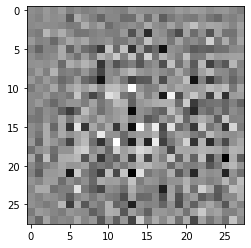

In [27]:


noise = tf.random.normal([1, 100])
generated_image = generator(noise,training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [28]:
generated_image.shape

TensorShape([1, 28, 28, 1])

In [43]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.l1=tf.keras.layers.Conv2D(64,(5,5), strides=(2,2), padding="same", input_shape=[28,28,1])
        self.l2=tf.keras.layers.LeakyReLU()
        self.l3=tf.keras.layers.Dropout(0.3)
        self.l4=tf.keras.layers.Conv2D(128,(5,5), strides=(2,2), padding="same")
        self.l5=tf.keras.layers.LeakyReLU()
        self.l6=tf.keras.layers.Dropout(0.3)
        self.l7=tf.keras.layers.Flatten()
        self.l8=tf.keras.layers.Dense(1)
        
    def call(self,x,training):
        
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x,training=training)
        x=self.l4(x)
        x=self.l5(x)
        x=self.l6(x,training=training)
        x=self.l7(x)
        out_dis=self.l8(x)
        
        return out_dis

In [44]:
discriminator = Discriminator()
decision = discriminator(generated_image,False)
print (decision)


tf.Tensor([[-0.00222292]], shape=(1, 1), dtype=float32)


# Define loss function
The loss here will be binary (fake or real)

In [45]:
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [46]:
def dicriminator_loss(real_output,fake_output):
    real_loss=loss_object(tf.ones_like(real_output), real_output)
    fake_loss=loss_object(tf.zeros_like(fake_output), fake_output)
    total_loss=real_loss+ fake_loss
    return total_loss

In [47]:
def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output),fake_output)

In [48]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [49]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [50]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# How This Work?

So generator takes up random values (noise_dim) to create image.<br>
we pass those values in the network and the image is passed in to the discriminator<br>
Discriminator take the real image and computes the loss.The loss is calulated some way like that yture=1 ypred=?<br>
Discriminator take the real image and computes the loss.The loss is calulated some way like that yture=0 ypred=?<br>
Generator loss is calculated<br>
Network is optimized<br>

So the loss is like<br>
realo-0(fails to detect)<br>
fakeo-1(as discriminator is not well trained)<br>
loss::dis1(1,0);loss high so dis_model updates:dis2(0,1);loss high dis_model update as it failed to detect fake:gen(1,1),loss low generator relax<br>
Discriminator learns a lot<br>
loss::dis1(1,1);loss low so dis_model relax it knows the original image:dis2(0,0);loss low dis_model relax as it pass to detect fake:gen(1,0),loss high generator update for better image<br>
Generator now will win over Discriminator<br>
loss::dis1(1,0);loss high so dis_model updates:dis2(0,1);loss high dis_model update as it failed to detect fake:gen(1,1),loss low generator relax<br>
Discriminator learns a lot<br>
and so on

In [51]:
@tf.function
def train_step(images):
    noise=tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,True)
        image_output=discriminator(images,True)
        gen_dis_output=discriminator(generated_images,True)
        
        dis_loss=dicriminator_loss(image_output, gen_dis_output)
        gen_loss=generator_loss(gen_dis_output)
        
    gradients_gen=gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_dis=disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_dis,discriminator.trainable_variables))
    
    return gen_loss, dis_loss

In [52]:
el="#"

In [53]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start=time.time()
        loss_g_ar=0
        loss_d_ar=0
        loss_g=0
        loss_d=0
        i=0
        print("EPOCH::{}".format(epoch+1))
        for image in dataset:
            i+=1
            loss_g,loss_d=train_step(image)
            loss_g_ar+=loss_g
            loss_d_ar+=loss_d
            percentage=(i/234)*10
            print("[{}]  {}%  GenerativeLoss::{} DiscriminatorLoss::{}".format(el*math.floor(percentage),percentage*10,loss_g_ar,loss_d_ar),end="\r",flush=True)
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print("Time taken:: {}s".format(time.time()-start))
        


            

In [54]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input,False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


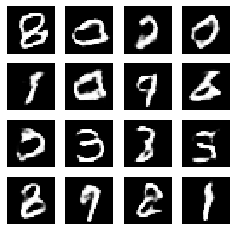

Time taken:: 9.345571994781494s


In [55]:
train(train_dataset,100)

In [56]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [57]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format
                        (epoch_no))


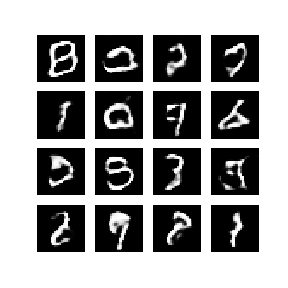

In [58]:
display_image(EPOCHS)


In [78]:
prediction=generator(noise,False)

In [82]:
predict=tf.reshape(prediction,[1,28,28])

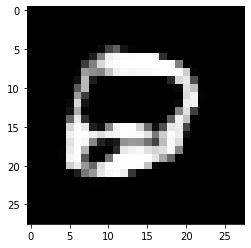

In [87]:
plt.imshow(predict[0] , cmap="gray")

In [85]:
predict

<tf.Tensor: id=185955, shape=(1, 28, 28), dtype=float32, numpy=
array([[[-0.9966446 , -0.9997664 , -0.9999508 , -0.9997979 ,
         -0.9996238 , -0.99955964, -0.9999749 , -0.999992  ,
         -0.9999987 , -0.9999968 , -0.9999983 , -0.99999684,
         -0.9999984 , -0.99999577, -0.9999995 , -0.9999998 ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ],
        [-0.9999221 , -0.9999988 , -0.9999997 , -0.99999785,
         -0.99999464, -0.9999966 , -0.99999994, -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ],
        [-0.9999782 , -0.99999994, -1.        , -1.        ,
         -1.       

In [83]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
